In [23]:
import numpy as np
import scipy.io as sio
import os
import glob
from scipy import sparse
import random as rd
from keras.models import Sequential 
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
import keras
import pandas as pd
import csv
from random import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
seed = 7
np.random.seed(seed)
# from unittest import Testcase

In [11]:
dictionary = pd.read_csv('../data/dictionary.csv')

# Reconstruct dataset

### create species dictinary:
    create a dictionary between species and their positions

### Read feature from file functions

In [12]:
def readSpecFeature(file_name):
    content = sio.loadmat(file_name)
#     print (content)
    return content['fullspecData']

In [13]:
def readSpatiaFeature(file_name):
#     print file_name
    content = sio.loadmat(file_name)
#     print (content)
    return content['spatialMat']


In [14]:
def loadSpatialData(species, dictPath = '../data/dictionary.csv', dictionary = None):
    if dictionary is None:
        dictionary = pd.read_csv(dictPath)
    listSpecies = dictionary['species']
#     temp = listSpecies[listSpecies == species]
#     print temp.index.size
    index = listSpecies[listSpecies == species].index[0]
    firstPath = dictionary['1st_spatial_path'][index]
    secondPath = dictionary['2st_spatial_path'][index]
    firstFeatures = readSpatiaFeature(firstPath)
    secondFeatures = readSpatiaFeature(secondPath)
    return np.concatenate((firstFeatures, secondFeatures), axis = 0)

In [15]:
def loadSpecData(species, dictPath = '../data/dictionary.csv', dictionary = None):
    if dictionary is None:
        dictionary = pd.read_csv(dictPath)
    listSpecies = dictionary['species']
#     temp = listSpecies[listSpecies == species]
#     print temp.index.size
    index = listSpecies[listSpecies == species].index[0]
    firstPath = dictionary['1st_spec_path'][index]
    secondPath = dictionary['2st_spec_path'][index]
    firstFeatures = readSpecFeature(firstPath)
    secondFeatures = readSpecFeature(secondPath)
#     print secondFeatures.shape
    return np.concatenate((firstFeatures, secondFeatures), axis = 0)

### prepare spatial sub-dataset


(576, 256)
96


/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.re

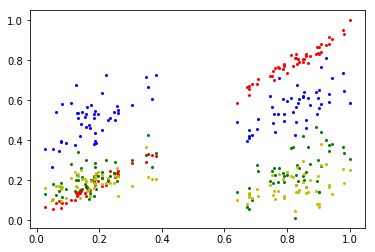

In [16]:
species = ['NDC1', 'NV1', 'NepCoTien', 'NepThomBacHai', 'NepThomHungYen', 'NepDacSanLienHoa']
nFeatures = 256
# nFeatures = 6
nClasses = len(species)

for i in range(0, len(species)):
    if i == 0:
        data = loadSpecData(species[i])
#         data = loadSpatialData(species[i])
#         data = [data]
#         print data.shape
    else:
        dataTemp = loadSpecData(species[i])
        data = np.concatenate((data, dataTemp), axis = 0)
print data.shape

nSamples = data.shape[0]/nClasses
print nSamples

trainRatio = 0.84
negRatio = 0.2
nTrainingSamples = int(trainRatio * nSamples)
nTestSamples = nSamples - nTrainingSamples
nNegTrainingSamples = int(negRatio * nTrainingSamples)

# temp = data.reshape(nSamples*nClasses,nFeatures)
for i in range(0, nFeatures):
    data[:,i] = min_max_scaler.fit_transform(data[:, i])

data = data.reshape(nClasses, nSamples, nFeatures)

plt.figure(1)
# plt.axis([0, 1, 0, 1])
# plt.subplot(221)
# X = range (0, data.shape[1])
plt.plot(data[0, :, 3], data[0, :, 5], 'or', markersize = 2)

# plt.subplot(222)
plt.plot(data[0, :, 3], data[1, :, 5], 'ob', markersize = 2)

# plt.subplot(223)
plt.plot(data[0, :, 3], data[2, :, 5], 'og', markersize = 2)

# plt.subplot(224)
plt.plot(data[0, :, 3], data[3, :, 5], 'oy', markersize = 2)
plt.show()

### separate function:
    separete feature set to train set and test set
    input:
        features: set of features
        trainRatio: the ratio between training data and the whole data
    return:
        training set and testing set

In [17]:
def separate(data, trainRatio = 0.84):
    np.random.shuffle(data)
    trainingData = data[0:int(trainRatio*data.shape[0])]
    testingData = data[int(trainRatio*data.shape[0]): data.shape[0]]
    return trainingData, testingData

In [18]:
for i in range (0, data.shape[0]):
    if i == 0:
        posTraining, val = separate(data[i, :, :], trainRatio)
        negTraining, _ = separate(posTraining, negRatio)
    else:
        posTrainingTemp, valTemp = separate(data[i, :, :], trainRatio)
        posTraining = np.concatenate((posTraining, posTrainingTemp),axis = 0)
        val = np.concatenate((val, valTemp), axis = 0)
        negTrainingTemp, _ = separate(posTrainingTemp, negRatio)
        negTraining = np.concatenate((negTraining, negTrainingTemp), axis = 0)
posTraining = posTraining.reshape(nClasses, nTrainingSamples, nFeatures)
val = val.reshape(nClasses, nTestSamples, nFeatures)
negTraining = negTraining.reshape(nClasses, nNegTrainingSamples, nFeatures)

In [19]:
def generateDatasetForBinaryClassification(speciesPosition):
    speciesPosition = 0
    posSamples = posTraining[speciesPosition, :, :]
    posLabels = np.asarray([0] * (posSamples.shape[0])).T
    negPositions = np.asarray(range(0, speciesPosition) + range(speciesPosition + 1, posTraining.shape[0]))
    # print negPositions
    negSamples = negTraining[negPositions, :, :]
    negSamples = negSamples.reshape((nClasses - 1) * nNegTrainingSamples, nFeatures)
    # print negSamples.shape
    negLabels = np.asarray([1] * (posSamples.shape[0])).T
    allTrainData = np.concatenate((posSamples, negSamples), axis = 0)
    allTrainLabels = np.concatenate((posLabels, negLabels), axis = 0)

    posTestSamples = val[speciesPosition, :, :]
    posTestLabels = np.asarray([0] * (posTestSamples.shape[0])).T
    negTestSamples = val[negPositions, :, :]
    negTestSamples = negTestSamples.reshape((nClasses - 1) * nTestSamples, nFeatures)
    negTestLabels = np.asarray([1] * (negTestSamples.shape[0])).T
    allTestData = np.concatenate((posTestSamples, negTestSamples), axis = 0)
    allTestLabels = np.concatenate((posTestLabels, negTestLabels), axis = 0)
    return allTrainData, allTrainLabels, allTestData, allTestLabels

In [54]:
speciesPosition = 0
allTrainData, allTrainLabels, allTestData, allTestLabels =generateDatasetForBinaryClassification(speciesPosition)
index = range(0, allTrainData.shape[0])
shuffle(index)
# print index
allTrainData = allTrainData[index, :]
allTrainLabels = allTrainLabels[index]

In [55]:
model = Sequential()
model.add(Dense(100, input_dim=nFeatures, init='uniform', activation='relu'))
model.add(Dense(200, init='uniform', activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(200, init='uniform', activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(1, init='uniform', activation='sigmoid'))

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit the model
# model.fit(trainingData1, trainingLabels1, epochs=200, batch_size=10, validation_data = (testData1,testLabels1))
model.fit(allTrainData, allTrainLabels, epochs=200, batch_size=10, validation_data = (allTestData,allTestLabels), verbose = 1)
scores = model.evaluate(allTestData,allTestLabels)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(100, activation="relu", kernel_initializer="uniform", input_dim=256)`
  
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(200, activation="relu", kernel_initializer="uniform")`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(200, activation="relu", kernel_initializer="uniform")`
  """
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", kernel_initializer="uniform")`
  import sys


Train on 160 samples, validate on 96 samples
Epoch 1/200
160/160 [==============================] - 0s - loss: 0.6940 - acc: 0.4875 - val_loss: 0.6876 - val_acc: 0.8542
Epoch 2/200
160/160 [==============================] - 0s - loss: 0.6903 - acc: 0.5563 - val_loss: 0.6699 - val_acc: 0.8333
Epoch 3/200
160/160 [==============================] - 0s - loss: 0.6887 - acc: 0.5250 - val_loss: 0.6358 - val_acc: 0.8542
Epoch 4/200
160/160 [==============================] - 0s - loss: 0.6500 - acc: 0.6812 - val_loss: 0.7760 - val_acc: 0.2292
Epoch 5/200
160/160 [==============================] - 0s - loss: 0.6378 - acc: 0.6313 - val_loss: 0.4101 - val_acc: 0.8437
Epoch 6/200
160/160 [==============================] - 0s - loss: 0.5985 - acc: 0.6625 - val_loss: 0.4824 - val_acc: 0.7604
Epoch 7/200
160/160 [==============================] - 0s - loss: 0.5392 - acc: 0.7250 - val_loss: 0.5485 - val_acc: 0.7396
Epoch 8/200
160/160 [==============================] - 0s - loss: 0.5264 - acc: 0.7125 

160/160 [==============================] - 0s - loss: 0.3675 - acc: 0.8312 - val_loss: 0.7907 - val_acc: 0.6979
Epoch 67/200
160/160 [==============================] - 0s - loss: 0.4154 - acc: 0.8000 - val_loss: 0.3950 - val_acc: 0.8125
Epoch 68/200
160/160 [==============================] - 0s - loss: 0.3689 - acc: 0.8250 - val_loss: 0.4738 - val_acc: 0.7917
Epoch 69/200
160/160 [==============================] - 0s - loss: 0.3538 - acc: 0.8375 - val_loss: 0.3928 - val_acc: 0.8750
Epoch 70/200
160/160 [==============================] - 0s - loss: 0.3536 - acc: 0.8375 - val_loss: 0.4251 - val_acc: 0.8229
Epoch 71/200
160/160 [==============================] - 0s - loss: 0.3543 - acc: 0.8250 - val_loss: 0.4561 - val_acc: 0.8021
Epoch 72/200
160/160 [==============================] - 0s - loss: 0.3457 - acc: 0.8250 - val_loss: 0.3965 - val_acc: 0.8438
Epoch 73/200
160/160 [==============================] - 0s - loss: 0.3416 - acc: 0.8187 - val_loss: 0.5579 - val_acc: 0.7604
Epoch 74/200


160/160 [==============================] - 0s - loss: 0.3262 - acc: 0.8437 - val_loss: 0.5368 - val_acc: 0.8021
Epoch 132/200
160/160 [==============================] - 0s - loss: 0.3267 - acc: 0.8375 - val_loss: 0.3401 - val_acc: 0.8854
Epoch 133/200
160/160 [==============================] - 0s - loss: 0.3440 - acc: 0.8313 - val_loss: 0.4453 - val_acc: 0.8333
Epoch 134/200
160/160 [==============================] - 0s - loss: 0.3386 - acc: 0.8375 - val_loss: 0.4239 - val_acc: 0.8333
Epoch 135/200
160/160 [==============================] - 0s - loss: 0.3087 - acc: 0.8500 - val_loss: 0.4799 - val_acc: 0.7813
Epoch 136/200
160/160 [==============================] - 0s - loss: 0.3344 - acc: 0.8312 - val_loss: 0.5967 - val_acc: 0.7396
Epoch 137/200
160/160 [==============================] - 0s - loss: 0.3235 - acc: 0.8250 - val_loss: 0.4734 - val_acc: 0.8125
Epoch 138/200
160/160 [==============================] - 0s - loss: 0.2990 - acc: 0.8500 - val_loss: 0.6820 - val_acc: 0.7083
Epoch 

160/160 [==============================] - 0s - loss: 0.2803 - acc: 0.8313 - val_loss: 0.6230 - val_acc: 0.7500
Epoch 197/200
160/160 [==============================] - 0s - loss: 0.3130 - acc: 0.8500 - val_loss: 0.5490 - val_acc: 0.8125
Epoch 198/200
160/160 [==============================] - 0s - loss: 0.3047 - acc: 0.8375 - val_loss: 0.5902 - val_acc: 0.7604
Epoch 199/200
160/160 [==============================] - 0s - loss: 0.2978 - acc: 0.8562 - val_loss: 0.5138 - val_acc: 0.8229
Epoch 200/200
32/96 [=========>....................] - ETA: 0s
acc: 79.17%


In [27]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]


classifiers = [
    KNeighborsClassifier(5),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0), warm_start=True),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

In [53]:
print len(allTrainData), len(classifiers) + 1
for idx,(name, clf) in enumerate(zip(names, classifiers)):
    clf.fit(allTrainData, allTrainLabels)
    score = clf.score(allTestData, allTestLabels)
    print name+' score: '+str(score)

160 11
Nearest Neighbors score: 0.729166666667
Linear SVM score: 0.739583333333
RBF SVM score: 0.802083333333
Gaussian Process score: 0.802083333333
Decision Tree score: 0.84375
Random Forest score: 0.65625
Neural Net score: 0.770833333333
AdaBoost score: 0.822916666667
Naive Bayes score: 0.541666666667
QDA score: 0.510416666667


# previous experiment

## Prepare data for sp1

In [ ]:
posSamples = sp1Training
posLabels = np.asarray([0] * (posSamples.shape[0])).T
negSamples = np.concatenate((sp2Val, sp3Val, sp4Val, sp5Val, sp6Val), axis = 0)
negLabels = np.asarray([1] * (posSamples.shape[0])).T
allTrainData = np.concatenate((posSamples, negSamples), axis = 0)
allTrainLabels = np.concatenate((posLabels, negLabels), axis = 0)
posTestSamples = sp1Test
posTestLabels = np.asarray([0] * (posTestSamples.shape[0])).T
negTestSamples = np.concatenate((sp2Test, sp3Test, sp4Test, sp5Test, sp6Test), axis = 0)
negTestLabels = np.asarray([1] * (negTestSamples.shape[0])).T
allTestData = np.concatenate((posTestSamples, negTestSamples), axis = 0)
allTestLabels = np.concatenate((posTestLabels, negTestLabels), axis = 0)


In [ ]:
print sp1Data.shape
print sp2Data.shape
print sp3Data.shape
print sp4Data.shape
print sp5Data.shape
print sp6Data.shape

### test separate function

In [ ]:
separate(np.asarray([1,2,3,4,5,6,7,8,9,10]), 0.84)

### Separate dataset

### Assign labels for features

In [ ]:
seedsNumber = 96
speciesNumber = 6
trainingData = np.concatenate((sp1Training, sp2Training, sp3Training, sp4Training, sp5Training, sp6Training), axis = 0)
testData = np.concatenate((sp1Test, sp2Test, sp3Test, sp4Test, sp5Test, sp6Test), axis = 0)
testNum = seedsNumber - int(trainRatio * seedsNumber)
# originLabels = np.asarray([])
for i in range(0, speciesNumber):
    if i == 0:
        trainingLabels = np.asarray([i*1.0] * int(trainRatio * seedsNumber)).T
        testLabels = np.asarray([i*1.0] * (seedsNumber - int(trainRatio * seedsNumber))).T
    else:
        trainingLabels = np.concatenate((trainingLabels, np.asarray([i*1.0] * int(trainRatio * seedsNumber)).T), axis = 0)
        testLabels = np.concatenate((testLabels, np.asarray([i*1.0] *  testNum).T), axis = 0)

# originLabels = np.asarray([0] * seedsNumber)

In [ ]:
print (trainingData[0,:])

In [ ]:
standarVector = [100000, 1000, 100,  1, 0.1, 1]
trainingData1 = (trainingData/standarVector)
testData1 = (testData/standarVector)

In [ ]:
trainingLabels1 = keras.utils.to_categorical(trainingLabels, speciesNumber)
testLabels1 = keras.utils.to_categorical(testLabels, speciesNumber)

In [ ]:
index_shuf = range(trainingLabels.shape[0])
shuffle(index_shuf)
trainingLabels1= trainingLabels1[index_shuf]
trainingData1= trainingData1[index_shuf]
# print trainingLabels1[0:3,:]
# print trainingData.shape
# print testData.shape
# print testLabels.shape

### Normalize dataset

### Training

In [ ]:
# create model
# denseTrainingLabels = oneHostDense(trainingLabels, speciesNumber)
model = Sequential()
model.add(Dense(100, input_dim=6, init='uniform', activation='relu'))
model.add(Dense(200, init='uniform', activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(200, init='uniform', activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(6, init='uniform', activation='sigmoid'))

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# Fit the model
# model.fit(trainingData1, trainingLabels1, epochs=200, batch_size=10, validation_data = (testData1,testLabels1))
model.fit(trainingData1, trainingLabels1, epochs=500, batch_size=10, validation_data = (testData1,testLabels1), verbose = 1)
scores = model.evaluate(testData1,testLabels1)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

In [ ]:

scores = model.evaluate(testData1[0:30,:], testLabels1[0:30,:], batch_size = 1)

print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

In [ ]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

batch_size = 128
num_classes = 10
epochs = 12

# input image dimensions
img_rows, img_cols = 28, 28

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [ ]:
def dense_to_one_hot(labels_dense, num_classes):
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    return labels_one_hot


def read_images_from_disk(input_queue):
    label = input_queue[1]
    file_contents = tf.read_file(input_queue[0])
    example = tf.image.decode_jpeg(file_contents, channels=3)
    # example = tf.cast( example, tf.float32 )
    return example, label


# weight initialization
def weight_variable(shape, name):
    initial = tf.truncated_normal(shape, stddev=0.01, name=name)
    return tf.Variable(initial)


def bias_variable(shape, name):
    initial = tf.constant(0.1, shape=shape, name=name)
    return tf.Variable(initial)


# convolution
def conv(input, kernel, biases, k_h, k_w, c_o, s_h, s_w, padding="VALID", group=1):
    '''
    From https://github.com/ethereon/caffe-tensorflow
    '''
    c_i = input.get_shape()[-1]
    assert c_i % group == 0
    assert c_o % group == 0
    convolve = lambda i, k: tf.nn.conv2d(i, k, [1, s_h, s_w, 1], padding=padding)

    if group == 1:
        conv = convolve(input, kernel)
    else:
        input_groups = tf.split(3, group, input)
        kernel_groups = tf.split(3, group, kernel)
        output_groups = [convolve(i, k) for i, k in zip(input_groups, kernel_groups)]
        conv = tf.concat(3, output_groups)
    return tf.reshape(tf.nn.bias_add(conv, biases), [-1] + conv.get_shape().as_list()[1:])


def conv2d(x, W, stride_h, stride_w, padding='SAME'):
    return tf.nn.conv2d(x, W, strides=[1, stride_h, stride_w, 1], padding=padding)

In [ ]:
Z1 = np.dot(W1.T, testData1) + b1
A1 = np.maximum(Z1, 0)
Z2 = np.dot(W2.T, A1) + b2
predicted_class = np.argmax(Z2, axis=0)
print('training accuracy: %.2f %%' % (100*np.mean(predicted_class == testLabels)))

In [ ]:
# temp =np.asarray([[3.79972124e+08, 3.56288960e+08, 3.82851206e+08, 4.07529309e+08 , 4.10980228e+08, 4.12379986e+08, 3.89384120e+08, 3.67045052e+08, 3.89184024e+08, 3.46503916e+08] ,[-1.81584610e+09, -1.70266680e+09, -1.82960492e+09, -1.94753893e+09 ,-1.96403051e+09, -1.97071980e+09, -1.86082502e+09, -1.75406900e+09 ,-1.85986879e+09, -1.65590512e+09] ,[3.89424382e+08, 3.65152072e+08, 3.92375085e+08, 4.17667085e+08, 4.21203850e+08, 4.22638428e+08, 3.99070513e+08, 3.76175734e+08, 3.98865440e+08, 3.55123613e+08] ,[3.72062517e+08, 3.48872349e+08, 3.74881667e+08, 3.99046063e+08, 4.02425148e+08, 4.03795767e+08, 3.81278590e+08, 3.59404538e+08, 3.81082660e+08, 3.39290993e+08], [3.77618022e+08, 3.54081587e+08, 3.80479267e+08, 4.05004478e+08, 4.08434017e+08, 4.09825103e+08, 3.86971707e+08, 3.64771039e+08, 3.86772851e+08, 3.44357166e+08], [2.96762487e+08, 2.78265671e+08, 2.99011082e+08, 3.18284957e+08, 3.20980164e+08, 3.22073390e+08, 3.04113361e+08, 2.86666299e+08, 3.03957084e+08, 2.70623441e+08]])
# # temp =np.asarray([[3,2,1], [5,6,7]])
# print (temp.shape)
# print (softmax(temp[:, 1]))
# a = softmax(temp)
# print (a)
# scores = [3.0e8, 1.0e8, 2e8]
scores = [3.0, 1.0, 2]
print(softmax(scores))

In [ ]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals
import math
import numpy as np
import matplotlib.pyplot as plt

N = 100 # number of points per class
d0 = 2 # dimensionality
C = 3 # number of classes
X = np.zeros((d0, N*C)) # data matrix (each row = single example)
y = np.zeros(N*C, dtype='uint8') # class labels

for j in xrange(C):
    ix = range(N*j,N*(j+1))
    r = np.linspace(0.0,1,N) # radius
    t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
    X[:,ix] = np.c_[r*np.sin(t), r*np.cos(t)].T
    y[ix] = j
print (X[1,:])
print ('y shape = ', y.shape)


In [ ]:
def softmax(V):
    e_V = np.exp(V - np.max(V, axis = 0, keepdims = True))
    Z = e_V / e_V.sum(axis = 0)
    return Z

## One-hot coding
from scipy import sparse
def convert_labels(y, C = 3):
    Y = sparse.coo_matrix((np.ones_like(y),
        (y, np.arange(len(y)))), shape = (C, len(y))).toarray()
    return Y

# cost or loss function
def cost(Y, Yhat):
    return -np.sum(Y*np.log(Yhat))/Y.shape[1]

In [ ]:
d0 = 2
d1 = h = 100 # size of hidden layer
d2 = C = 3

# test

X = trainingData1[1:3, 0:160]
d2 = C = 2
y = trainingLabels[0:160]
# initialize parameters randomly
W1 = 0.01*np.random.randn(d0, d1)
b1 = np.zeros((d1, 1))
W2 = 0.01*np.random.randn(d1, d2)
b2 = np.zeros((d2, 1))


Y = convert_labels(y, C)
N = X.shape[1]
eta = 1 # learning rate
for i in xrange(100):
    ## Feedforward
    Z1 = np.dot(W1.T, X) + b1
    A1 = np.maximum(Z1, 0)
    Z2 = np.dot(W2.T, A1) + b2
    Yhat = softmax(Z2)
    
    # backpropagation
    E2 = (Yhat - Y )/N
    dW2 = np.dot(A1, E2.T)
    db2 = np.sum(E2, axis = 1, keepdims = True)
    E1 = np.dot(W2, E2)
    E1[Z1 <= 0] = 0 # gradient of ReLU
    dW1 = np.dot(X, E1.T)
    db1 = np.sum(E1, axis = 1, keepdims = True)

    # Gradient Descent update
    W1 += -eta*dW1
    b1 += -eta*db1
    W2 += -eta*dW2
    b2 += -eta*db2

    # print loss after each 1000 iterations
    if i %1 == 0:
        # compute the loss: average cross-entropy loss
        loss = cost(Y, Yhat)
        print("iter %d, loss: %f, " %(i, loss))
#         print (dW1[1, 1])


In [ ]:
print (trainingData1.shape)
print (trainingData1[:, 7])
print (testLabels.shape)
# print (trainingLabels)
# print (testLabels)

In [ ]:
trainingData1 = trainingData.T
print (trainingData1[:, 1])
print (trainingData1[:, 90])
# print (1/0)

In [ ]:
# def softmax(V):
#     e_V = np.exp(V - np.max(V, axis = 0, keepdims = True))
#     Z = e_V / e_V.sum(axis = 0)
#     return Z

def oneHostDense(y, classNum = 6):
    Y = sparse.coo_matrix((
        np.ones_like(y), (y, np.arange(len(y)))), shape = (classNum, len(y))).toarray()
    return Y

# def cost(Y, Yhat):
#     return -np.sum(Y*np.log(Yhat))/Y.shape[1]

In [ ]:
# d0 = featuresDimension 
# d1 = h = 6
# # d1 is the output number of  hiden layer 1
# # h is the inputnumer of input number of output layer
# d2 = C = speciesNumber 
# # d2 is the output number of input layer (layer 2)
# # C is the number of species

# # initialize parameters randomly
# W1 = 0.0001 * np.random.randn(d0, d1) 
# b1 = np.zeros((d1, 1))
# #weights, bias between input layer and hidden layer

# W2 = 0.0001 * np.random.randn(d1, d2) 
# b2 = np.zeros((d2, 1))
# #weights, bias between hidden layer 2 and output layer

# denseTrainingLabels = oneHostDense(trainingLabels, C)
# trainingSampleNum = trainingData1.shape[1]
# learningRate = 1

# iteration = 10000

# for i in xrange(iteration):
#     Z1 = np.dot(W1.T, trainingData1) + b1 
#     #Z1 is the input of first hidden layer
#     A1 = np.maximum(Z1, 0)
#     #A1 is the output of first hidden layer
#     Z2 = np.dot(W2.T, A1) + b2
#     trainingPredictions = softmax(Z2)
#     #backpropagation
#     E2 = (trainingPredictions - denseTrainingLabels)/ trainingSampleNum
#     dW2 = np.dot(A1, E2.T)
#     db2 = np.sum(E2, axis = 1, keepdims = True)
    
#     E1 = np.dot(W2, E2)
#     E1[Z1 <= 0] = 0 #gradient of ReLU
#     dW1 = np.dot(trainingData1, E1.T)
#     db1 = np.sum(E1, axis = 1, keepdims = True)
    
#     #Gradient Descent update
#     W1 += -learningRate * dW1
#     b1 += -learningRate * db1
#     W2 += -learningRate * dW2
#     b2 += -learningRate * db2
    
#     if i%1000 == 0:
#         loss = cost(denseTrainingLabels, trainingPredictions)
#         print ("iteration %d, loss: %f" %(i, loss))
